In [1]:
import numpy as np
import pandas as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
import tensorflow as tf
from keras.layers.core import Dense, Activation, Dropout, Flatten
from sklearn.model_selection import train_test_split
import os
import random
import glob

In [2]:
# path_test = "./FruitsDataset/fruits-360_dataset/fruits-360/Training"
# classes=["Apple Red 1", "Apricot", "Avacoda", "Banana", "Beetroot", "Blueberry", "Cherry 1", "Dates", "Grape Blue",
#          "Grape Pink", "Grape White", "Corn", "Guava", "Kiwi", "Lychee", "Mango", "Onion Red", "Onion White", 
#          "Orange", "Papaya", "Peach", "Pear", "Pear2", "Potato Sweet", "Potato White", "Tomato 1", "Tomato 2", 
#          "Tomato 3", "Plum", "Plum 2", "Pomogranate", "Pineapple", "Potato Red", "Potato Red Washed", 
#          "Tomato not Ripened", "Watermelon"]

In [3]:
# training = []
# def createTrainingData():
#     for C1 in classes:
#         path = os.path.join(path_test, C1)
#         class_num = classes.index(C1)
#     for img in os.listdir(path):
#         img_array = cv2.imread(os.path.join(path,img))
#         training.append([img_array, class_num])

In [4]:
# createTrainingData()

In [5]:
Image_Size=256
Batch_Size=100
channels=3
epochs=25

In [6]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"./Fruits/fruits-360_dataset/fruits-360/Training",
shuffle=True,
    image_size= (Image_Size, Image_Size),
    batch_size=Batch_Size
)

Found 67692 files belonging to 131 classes.


In [7]:
class_names=dataset.class_names
class_names

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Apricot',
 'Avocado',
 'Avocado ripe',
 'Banana',
 'Banana Lady Finger',
 'Banana Red',
 'Beetroot',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe 1',
 'Cantaloupe 2',
 'Carambula',
 'Cauliflower',
 'Cherry 1',
 'Cherry 2',
 'Cherry Rainier',
 'Cherry Wax Black',
 'Cherry Wax Red',
 'Cherry Wax Yellow',
 'Chestnut',
 'Clementine',
 'Cocos',
 'Corn',
 'Corn Husk',
 'Cucumber Ripe',
 'Cucumber Ripe 2',
 'Dates',
 'Eggplant',
 'Fig',
 'Ginger Root',
 'Granadilla',
 'Grape Blue',
 'Grape Pink',
 'Grape White',
 'Grape White 2',
 'Grape White 3',
 'Grape White 4',
 'Grapefruit Pink',
 'Grapefruit White',
 'Guava',
 'Hazelnut',
 'Huckleberry',
 'Kaki',
 'Kiwi',
 'Kohlrabi',
 'Kumquats',
 'Lemon',
 'Lemon Meyer',
 'Limes',
 'Lychee',
 'M

In [8]:
len(dataset)

677

In [9]:
dataset.take(2)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

(256, 256, 3)


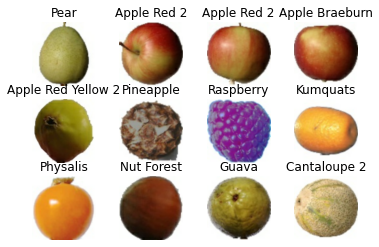

In [10]:
for image_batch, label_batch in dataset.take(1):
    for x in range (0, 12):
        ax=plt.subplot(3, 4, x+1)
        plt.imshow(image_batch[x].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[x]])
    print(image_batch[0].shape)
    
#     print(label_batch.numpy())

In [11]:
# 80% training & 20% (10% validation and 10% test data)

In [12]:
training_size=0.8
len(dataset)*training_size

541.6

In [13]:
train_ds=dataset.take(516)
len(train_ds)

516

In [14]:
test_ds=dataset.skip(516)
len(test_ds)

161

In [15]:
val_size=0.1
len(dataset)*val_size

67.7

In [16]:
val_ds=test_ds.take(64)
len(val_ds)

64

In [17]:
test_ds=test_ds.skip(64)
len(test_ds)

97

In [18]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
        ds_size=len(ds)
        if shuffle:
            ds=ds.shuffle(shuffle_size, seed=12)
            
        train_size=int(train_split*ds_size)
        val_size=int(val_split*ds_size)
        
        train_ds=ds.take(train_size)
        val_ds=ds.skip(train_size).take(val_size)
        test_ds=ds.skip(train_size).skip(val_size)
        
        return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds=get_dataset_partition_tf(dataset)

In [20]:
len(train_ds)

541

In [21]:
len(val_ds)

67

In [22]:
len(test_ds)

69

In [23]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [25]:
#NeuralNetwork Architecture
input_shape=(Batch_Size, Image_Size, Image_Size, channels)
n_classes=15
model=models.Sequential([
    resize_and_rescale,
#     data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),   
])
model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (100, 256, 256, 3)        0         
                                                                 
 conv2d (Conv2D)             (100, 254, 254, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (100, 127, 127, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (100, 125, 125, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (100, 62, 62, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (100, 60, 60, 64)        

In [27]:
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
)

In [ ]:
model.fit(
    train_ds, 
    epochs=epochs, 
    batch_size=Batch_Size, 
    verbose=1, 
    validation_data=val_ds
)

Epoch 1/25
455/541 [========================>.....] - ETA: 37s - loss: 27376677289984.0000 - accuracy: 0.0080